<a href="https://colab.research.google.com/github/vigu2021/NeuroSynth/blob/main/GanSynth_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom GANSynth-Based Note Generator

This project is a custom adaptation of the [GANSynth](https://arxiv.org/pdf/1902.08710) architecture for musical note synthesis.

We extend the original implementation by conditioning the model on a broader set of features from the NSynth dataset, including:

- `pitch` (MIDI, one-hot encoded)
- `velocity` (normalized scalar)
- `instrument_family` (one-hot encoded)
- `instrument_source` (one-hot encoded)
- `qualities` (binary vector)


The generator learns to produce log-mel spectrograms from a latent vector and conditioning inputs. The audio waveform is recovered via spectrogram inversion.

This implementation is based on the original work by the Magenta team:

> Engel, J., Hantrakul, L., Gu, C., & Roberts, A. (2019). *GANSynth: Adversarial Neural Audio Synthesis*. ICLR. [arXiv:1902.08710](https://arxiv.org/pdf/1902.08710)

---


 ## Model Pipeline

    [ Conditioning Vector + Noise ]
            ↓
        Generator (GAN)
            ↓
        Log-Mel Spectrogram
            ↓
        Inverse Spectrogram Transform (e.g., iSTFT + Griffin-Lim)
            ↓
        Audio (waveform)


In [ ]:
#Import necessary libraries
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader, Dataset
from google.colab import files
import os
from google.cloud import storage
import json
from concurrent.futures import ThreadPoolExecutor
import subprocess
import tarfile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F


In [ ]:
#Upload service account json file
key_file = files.upload()
filename = list(key_file.keys())[0]
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = filename


Saving nsynth-455415-069a347092e3.json to nsynth-455415-069a347092e3.json


In [ ]:
client = storage.Client()
bucket_name = "nsynth-data"
bucket = client.bucket(bucket_name)


blobs = bucket.list_blobs(prefix="", delimiter="/")
print("📁 Top-level folders:")
for page in blobs.pages:
    for prefix in page.prefixes:
        print(" -", prefix)

"""
Should print:

 - nsynth-test/
 - nsynth-train/
 - nsynth-valid/

 """



📁 Top-level folders:
 - file_names/
 - nsynth-test/
 - nsynth-train/
 - nsynth-valid/


'\nShould print:\n\n - nsynth-test/\n - nsynth-train/\n - nsynth-valid/\n\n '

#1. Data Loading and Preprocessing

In [ ]:
import os
import tarfile
import json
from pathlib import Path

import torchaudio
import torchaudio.transforms as T
from google.cloud import storage


def compress_and_upload_audio(
    bucket_name: str,
    gcs_input_path: str,
    gcs_output_path: str,
    target_sample_rate: int = 4000,
    split: str = "train",
):
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    local_tar_path = f"/tmp/{split}_source.tar.gz"
    extract_path = f"/tmp/{split}/unzipped"
    compressed_path = f"/tmp/{split}/compressed"
    final_tar_path = f"/tmp/{split}_resampled.tar.gz"

    os.makedirs(extract_path, exist_ok=True)
    os.makedirs(compressed_path, exist_ok=True)

    # 1. download archive from GCS
    print("📥  Downloading tar.gz from GCS …")
    bucket.blob(gcs_input_path).download_to_filename(local_tar_path)

    # 2. extract
    print("📦  Extracting archive …")
    with tarfile.open(local_tar_path, "r:gz") as tar:
        tar.extractall(path=extract_path)

    # 2.5 locate examples.json (metadata)
    meta_path = next(
        (p for p in Path(extract_path).rglob("examples.json")), None
    )
    if meta_path is None:
        raise FileNotFoundError("❌  examples.json not found inside archive")

    with open(meta_path, "r") as f:
        metadata = json.load(f)

    # 3. resample .wav files (only MIDI 24‑84)
    print("🎧  Resampling .wav files …")
    files_resampled = 0
    resampler_cache = {}

    for wav_file in Path(extract_path).rglob("*.wav"):
        file_id = wav_file.stem
        if file_id not in metadata:
            continue

        midi = metadata[file_id]["pitch"]   # NSynth key is 'pitch'
        if not (24 <= midi <= 84):
            continue  # skip notes outside desired range

        rel_path = wav_file.relative_to(extract_path)
        out_file = Path(compressed_path) / rel_path
        out_file.parent.mkdir(parents=True, exist_ok=True)

        audio, sample_rate = torchaudio.load(str(wav_file))
        if sample_rate != target_sample_rate:
            if sample_rate not in resampler_cache:
                resampler_cache[sample_rate] = T.Resample(
                    orig_freq=sample_rate, new_freq=target_sample_rate
                )
            audio = resampler_cache[sample_rate](audio)

        torchaudio.save(
            str(out_file),
            audio,
            target_sample_rate,
            encoding="PCM_S",
            bits_per_sample=16,
        )
        files_resampled += 1
        if files_resampled % 1000 == 0:
            print(f"   – processed {files_resampled:,} files")

    # 4. re‑tar the resampled files
    print("📚  Creating new .tar.gz …")
    with tarfile.open(final_tar_path, "w:gz") as tar_out:
        for file in Path(compressed_path).rglob("*"):
            tar_out.add(file, arcname=file.relative_to(compressed_path))

    print(
        f"✅  Finished: {files_resampled:,} file(s) resampled "
        f"and archived at {final_tar_path}"
    )

    # 5. upload back to GCS
    bucket.blob(gcs_output_path).upload_from_filename(final_tar_path)
    print(f"☁️  Uploaded to gs://{bucket_name}/{gcs_output_path}")


In [ ]:
#Run this if only folder not in GCS already
'''
bucket_name = "nsynth-data"
gcs_input_path = "nsynth-train.jsonwav.tar.gz"
gcs_output_path = "nsynth-train_resampled.jsonwav.tar.gz"
target_sample_rate = 4000
split = "train"

compress_and_upload_audio(bucket_name,gcs_input_path,gcs_output_path,target_sample_rate,split)
'''

'\nbucket_name = "nsynth-data"\ngcs_input_path = "nsynth-train.jsonwav.tar.gz"\ngcs_output_path = "nsynth-train_resampled.jsonwav.tar.gz"\ntarget_sample_rate = 4000\nsplit = "train"\n\ncompress_and_upload_audio(bucket_name,gcs_input_path,gcs_output_path,target_sample_rate,split)\n'

In [ ]:
import tarfile
from google.cloud import storage

def download_dataset(gcs_input_path, split, bucket_name="nsynth-data"):
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    local_tar_path = f"/tmp/{split}_source.tar.gz"
    extract_path = f"/tmp/{split}/unzipped"
    os.makedirs(extract_path, exist_ok=True)

    # 1. Download the tar.gz file from GCS
    print("✅ Starting download!")
    bucket.blob(gcs_input_path).download_to_filename(local_tar_path)

    # 2. Extract contents to target path
    with tarfile.open(local_tar_path, "r:gz") as tar:
        tar.extractall(path=extract_path)

    print(f"✅ Downloaded and extracted {gcs_input_path} to {extract_path}")
    return extract_path


def json_file(json_path,split,bucket_name = "nsynth-data"):
  client = storage.Client()
  bucket = client.bucket(bucket_name)

  local_json_path = f"/tmp/{split}.json"
  bucket.blob(json_path).download_to_filename(local_json_path)
  print(f"✅ Downloaded {json_path} to {local_json_path}")
  return local_json_path





In [ ]:
import os
import json
import torch
import torchaudio
from pathlib import Path
from torch.utils.data import Dataset

class NSynthDataset(Dataset):
    def __init__(self, split="train", local_cache_dir="/tmp/"):
        super().__init__()
        self.root_dir = Path(local_cache_dir) / split / "unzipped"

        # 1. Load the JSON labels
        label_path = Path(local_cache_dir) / f"{split}.json"
        if not label_path.exists():
            raise FileNotFoundError(f"Label file not found: {label_path}")
        with open(label_path, "r") as f:
            self.labels = json.load(f)

        # 2. Scan all WAV files
        wav_paths = list(self.root_dir.rglob("*.wav"))
        if not wav_paths:
            raise FileNotFoundError(f"No .wav files under {self.root_dir}")
        self.wav_map = {p.stem: p for p in wav_paths}

        # 3. Filter labels to only those with existing WAVs
        all_keys = list(self.labels.keys())
        self.file_names = [fn for fn in all_keys if fn in self.wav_map]
        skipped = len(all_keys) - len(self.file_names)
        if skipped:
            print(f"⚠️  Skipped {skipped} label(s) without audio files")

        # 4. Velocity mapping
        self.velocity_map = {25: 0, 50: 1, 75: 2, 100: 3, 127: 4}

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        fn = self.file_names[idx]
        wav_path = self.wav_map[fn]

        # Load audio
        audio, sr = torchaudio.load(str(wav_path))

        # Fetch metadata
        m = self.labels[fn]
        return {
            "pitch":             torch.tensor(m["pitch"], dtype=torch.long),
            "velocity":          torch.tensor(self.velocity_map[int(m["velocity"])], dtype=torch.long),
            "instrument_family": torch.tensor(m["instrument_family"], dtype=torch.long),
            "instrument_source": torch.tensor(m["instrument_source"], dtype=torch.long),
            "qualities":         torch.tensor(m["qualities"], dtype=torch.long),
            "audio":             audio,
        }



##2. Create the GANsynth Model

## 🎛 Embedding-Based Conditioning for GAN

This model uses **learned embeddings** and encoded binary vectors to represent conditioning features from the NSynth dataset. Each feature is embedded or projected into a lower-dimensional continuous space and concatenated to form a high-dimensional vector. This vector conditions both the **generator** and **discriminator** networks.

### 🔢 Feature Embedding Dimensions

| Feature               | Value Range                | Representation Type     | Output Dimension |
|------------------------|-----------------------------|--------------------------|------------------|
| **Pitch**             | 0–127 (128 classes)         | Embedding                | 18               |
| **Velocity**          | {25, 50, 75, 100, 127} (5 classes)| Embedding                | 3                |
| **Instrument Family** | 0–10 (11 classes)           | Embedding                | 5                |
| **Instrument Source** | 0–2 (3 classes)             | Embedding                | 3                |
| **Qualities**         | 10-dim binary vector        | Linear projection (`10 → 10`) | 10              |

- All categorical features use **`nn.Embedding(num_classes, embed_dim)`**.
- The embedding dimensions are determined using the following heuristic formula:

> 📐 **Embedding Dimension = ⌈1.6 × √(num_classes)⌉**

- `Qualities` is a multi-label binary vector (e.g., distorted, bright, percussive).
- It is projected to 10 dimensions using a small feedforward layer:  
  `projected_qualities = Linear(10, 10)(qualities)`

### 📐 Total Conditioning Vector Size

All conditioning features are concatenated into one vector:

**18 (pitch) + 3 (velocity) + 5 (instrument family) + 3 (instrument source) + 10 (qualities) = 39 dimensions**

This **39-dimensional conditioning vector** is concatenated with the latent noise vector `z` and passed into the generator and discriminator networks, enabling the GAN to synthesize high-quality, controllable musical notes that reflect both physical and perceptual attributes of sound.


#2.1  PixelNorm (Pixel-wise Feature Normalization)

PixelNorm is a normalization layer used in GANSynth generators
It operates **per pixel** and normalizes the **channel-wise feature vector** to have **unit average squared magnitude**.

---

## 📐 Formula

For a 4D input tensor `x` of shape `(B, C, H, W)`, the PixelNorm formula is:
$$
[
\text{PixelNorm}(x_{b,c,h,w}) = \frac{x_{b,c,h,w}}{\sqrt{\frac{1}{C} \sum_{c=1}^{C} x_{b,c,h,w}^2 + \epsilon}}
]
$$


In [ ]:
# PixelNorm block
# It normalizes each pixel by considering all channels at that pixel location.
# The normalization ensures that the **average variance across channels** for each pixel is ≈ 1.

class PixelNorm(nn.Module):
  def __init__(self,epsilon = 1e-8):
    super().__init__()
    self.epsilon = epsilon
  def forward(self, x):
    return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)





## 🔼 Upsampling ×2 Block (GANSynth Style)

This block is a core component in the generator architecture. It progressively increases the spatial resolution (height × width) of the feature map while refining features through convolutional layers.

### 🧱 Block Structure

The Upsampling ×2 Block consists of the following:

1. **Nearest-Neighbor Upsampling**  
   - Doubles both the height and width of the feature map  
   - e.g., (H, W) → (2H, 2W)

2. **Two Conv2D Layers**  
   - Each with:
     - `kernel_size = 3`
     - `stride = 1`
     - `padding = 1`


### 🔁 Full Layer Sequence

```plaintext
Input (B, C, H, W)
↓
Upsample (scale_factor=2) → (B, C, 2H, 2W)
↓
Conv2D (3×3, stride=1, padding=1) → (B, C_out, 2H, 2W)
↓
PixelNorm
↓
LeakyReLU
↓
Conv2D (3×3, stride=1, padding=1) → (B, C_out, 2H, 2W)
↓
PixelNorm
↓
LeakyReLU


In [ ]:
#Doubles the width and height by factor of 2


class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm1 = PixelNorm()
        self.act1 = nn.LeakyReLU(0.2)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.norm2 = PixelNorm()
        self.act2 = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.upsample(x)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act2(x)

        return x



##2.2 Generator Architecture Implementation


The generator progressively upsamples a low-dimensional latent vector `z`, conditioned on attributes such as pitch, instrument family, velocity, and qualities. It uses:

- **Nearest-neighbor upsampling**
- **2D convolutional blocks**
- **PixelNorm** normalization
- **LeakyReLU** activations

Each block approximately doubles the resolution of the spectrogram representation, ending in a 2-channel output (real and imaginary components).

📷 **The diagram of the GANSynth generator architecture will be used as a reference for implementation.**


“For the mini model, we remove the last two upsampling blocks, reducing its output dimensions to (2, 32, 256) instead of (2, 128, 1024)."
## 🎛️ GANSynth Generator Architecture - Taken from original paper

| Layer Description      | Output Size          | Kernel Size | Filters | Nonlinearity       |
|------------------------|----------------------|-------------|---------|--------------------|
| concat(Z, Pitch)       | (1, 1, 317)          | -           | -       | -                  |
| Conv2D                 | (2, 16, 256)         | 2 × 16      | 256     | PN + LeakyReLU     |
| Conv2D                 | (2, 16, 256)         | 3 × 3       | 256     | PN + LeakyReLU     |
| Upsample (2×2)         | (4, 32, 256)         | -           | -       | -                  |
| Conv2D                 | (4, 32, 256)         | 3 × 3       | 256     | PN + LeakyReLU     |
| Conv2D                 | (4, 32, 256)         | 3 × 3       | 256     | PN + LeakyReLU     |
| Upsample (2×2)         | (8, 64, 256)         | -           | -       | -                  |
| Conv2D                 | (8, 64, 256)         | 3 × 3       | 256     | PN + LeakyReLU     |
| Conv2D                 | (8, 64, 256)         | 3 × 3       | 256     | PN + LeakyReLU     |
| Upsample (2×2)         | (16, 128, 256)       | -           | -       | -                  |
| Conv2D                 | (16, 128, 256)       | 3 × 3       | 256     | PN + LeakyReLU     |
| Conv2D                 | (16, 128, 256)       | 3 × 3       | 256     | PN + LeakyReLU     |
| Upsample (2×2)         | (32, 256, 256)       | -           | -       | -                  |
| Conv2D                 | (32, 256, 128)       | 3 × 3       | 128     | PN + LeakyReLU     |
| Conv2D                 | (32, 256, 128)       | 3 × 3       | 128     | PN + LeakyReLU     |
| Upsample (2×2)         | (64, 512, 128)       | -           | -       | -                  |
| Conv2D                 | (64, 512, 64)        | 3 × 3       | 64      | PN + LeakyReLU     |
| Conv2D                 | (64, 512, 64)        | 3 × 3       | 64      | PN + LeakyReLU     |
| Upsample (2×2)         | (128, 1024, 64)      | -           | -       | -                  |
| Conv2D                 | (128, 1024, 32)      | 3 × 3       | 32      | PN + LeakyReLU     |
| Conv2D                 | (128, 1024, 32)      | 3 × 3       | 32      | PN + LeakyReLU     |




In [ ]:

class mini_Generator_v1(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        # Embedding and projection layers for conditioning
        self.pitch_embedding = nn.Embedding(128, 36)
        self.velocity_embedding = nn.Embedding(5, 6)
        self.instrument_family_embedding = nn.Embedding(11, 10)
        self.instrument_source_embedding = nn.Embedding(3, 6)
        self.quality_projection = nn.Linear(10, 20)

        self.latent_dim = latent_dim
        self.activation = nn.LeakyReLU(0.2)
        self.pixel_norm = PixelNorm()

        # Initial linear projection to shape (256, 2, 16)
        self.initial_linear = nn.Linear(latent_dim + 78, 256 * 2 * 16)
        self.initial_conv = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # Upsampling stack (progressively increasing H, W)
        self.upsample_layers = nn.Sequential(
            UpsampleBlock(256, 128),
            UpsampleBlock(128, 64),
            UpsampleBlock(64, 32),
            UpsampleBlock(32, 16),
        )

        # Final conv and output activation
        self.last_conv = nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1)
        self.output_activation = nn.Tanh()

    def forward(self, batch, z):
        # Embeddings and projection
        pitch_emb = self.pitch_embedding(batch["pitch"])                     # (B, 36)
        velocity_emb = self.velocity_embedding(batch["velocity"])           # (B, 6)
        inst_family_emb = self.instrument_family_embedding(batch["instrument_family"])  # (B, 10)
        inst_source_emb = self.instrument_source_embedding(batch["instrument_source"])  # (B, 6)
        quality_proj = self.quality_projection(batch["qualities"].float())  # (B, 20)

        # Combine all conditioning vectors + latent z
        cond_vec = torch.cat([
            pitch_emb, velocity_emb, inst_family_emb,
            inst_source_emb, quality_proj, z
        ], dim=1)  # (B, 206)

        # Initial projection and conv
        x = self.initial_linear(cond_vec)                   # (B, 8192)
        x = x.view(x.size(0), 256, 2, 16)                   # (B, 256, 2, 16)
        x = self.initial_conv(x)                            # (B, 256, 2, 16)
        x = self.pixel_norm(x)
        x = self.activation(x)

        # Upsample to final resolution
        x = self.upsample_layers(x)                         # → (B, 2 , 32, 256)

        # Final conv + output scaling
        x = self.last_conv(x)                               # (B, 2, 32, 256)
        x = self.output_activation(x)                       # [-1, 1] range

        return x








## 2.3 🎚️ Discriminator Architecture

The discriminator receives the **generated (or real) spectrogram** from the generator with shape `(32, 256, 2)`, and progressively **downsamples** it through a series of convolutional blocks. The final outputs are:

- A **real/fake score**, represented as a **single scalar value** per sample indicating whether the input is real or generated.
- A **conditioning regression head**, which predicts a **39-dimensional embedding vector** representing the original conditioning inputs (e.g., pitch, velocity, instrument family, source, and qualities).


### 🧱 Block-wise Architecture

| Layer Description         | Output Size         | Kernel Size | Filters | Nonlinearity       |
|---------------------------|----------------------|-------------|---------|--------------------|
| Input image               | (128, 1024, 2)       | -           | -       | -                  |
| Conv2D                    | (128, 1024, 32)      | 1 × 1       | 32      | -                  |
| Conv2D                    | (128, 1024, 32)      | 3 × 3       | 32      | LeakyReLU          |
| Conv2D                    | (128, 1024, 32)      | 3 × 3       | 32      | LeakyReLU          |
| Downsample (stride=2)     | (64, 512, 32)        | -           | -       | -                  |
| Conv2D                    | (64, 512, 64)        | 3 × 3       | 64      | LeakyReLU          |
| Conv2D                    | (64, 512, 64)        | 3 × 3       | 64      | LeakyReLU          |
| Downsample (stride=2)     | (32, 256, 64)        | -           | -       | -                  |
| Conv2D                    | (32, 256, 128)       | 3 × 3       | 128     | LeakyReLU          |
| Conv2D                    | (32, 256, 128)       | 3 × 3       | 128     | LeakyReLU          |
| Downsample (stride=2)     | (16, 128, 128)       | -           | -       | -                  |
| Conv2D                    | (16, 128, 256)       | 3 × 3       | 256     | LeakyReLU          |
| Conv2D                    | (16, 128, 256)       | 3 × 3       | 256     | LeakyReLU          |
| Downsample (stride=2)     | (8, 64, 256)         | -           | -       | -                  |
| Conv2D                    | (8, 64, 256)         | 3 × 3       | 256     | LeakyReLU          |
| Conv2D                    | (8, 64, 256)         | 3 × 3       | 256     | LeakyReLU          |
| Downsample (stride=2)     | (4, 32, 256)         | -           | -       | -                  |
| Conv2D                    | (4, 32, 256)         | 3 × 3       | 256     | LeakyReLU          |
| Conv2D                    | (4, 32, 256)         | 3 × 3       | 256     | LeakyReLU          |
| Downsample (stride=2)     | (2, 16, 256)         | -           | -       | -                  |
| **Minibatch Std. Concat** | (2, 16, 257)         | -           | -       | -                  |
| Conv2D                    | (2, 16, 256)         | 3 × 3       | 256     | LeakyReLU          |
| Conv2D                    | (2, 16, 256)         | 3 × 3       | 256     | LeakyReLU          |
| **Pitch classifier**      | (1, 1, 61)           | -           | 61      | Softmax            |
| **Discriminator output**  | (1, 1, 1)            | -           | 1       | - (linear)         |

---



In [ ]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.downsample = nn.Sequential(
            # Downsampling: keep channels, reduce spatial size
            nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding),  # (B, C, H, W) -> (B, C, H/2, W/2)
            nn.LeakyReLU(0.2),

            # Refinement: increase channels, preserve spatial size
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),  # (B, C, H/2, W/2) -> (B, C_out, H/2, W/2)
            nn.LeakyReLU(0.2),

            nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.downsample(x)


In [ ]:
class mini_Discriminator_v1(nn.Module):
  def __init__(self):
    super().__init__()

    # Initial convolutional block
    self.initial_block = nn.Sequential(
        nn.Conv2d(2, 32, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2)
    )

    # Downsampling stack
    self.downsample_block = nn.Sequential(
        DownsampleBlock(32, 64),     # 32x256 → 16x128
        DownsampleBlock(64, 128),    # 16×128 → 8×64
        DownsampleBlock(128, 256),   # 8×64 → 4×32
     )

    # Final spatial downsampling
    self.final_downsample = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),  # → 2×16
        nn.LeakyReLU(0.2)
    )

    # Convolution after concatenating std channel
    self.final_conv = nn.Sequential(
        nn.Conv2d(257, 256, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2)
    )

    # Conditioning regressor (outputs 39D vector)
    self.cond_regressor = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(256, 78)
    )

    # Real/fake score classifier
    self.real_classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(256, 1)
    )

  def forward(self, x):
    x = self.initial_block(x)
    x = self.downsample_block(x)
    x = self.final_downsample(x)

    # Append mean of std channel across batch
    x_std = torch.std(x, dim=0, keepdim=True).mean()
    x_std = x_std.expand(x.shape[0], 1, x.shape[2], x.shape[3])
    x = torch.cat([x, x_std], dim=1)

    x = self.final_conv(x)

    x_cond = self.cond_regressor(x)       # → (B, 78)
    x_classifier = self.real_classifier(x)  # → (B, 1)

    return {
    "condition": x_cond,       # 39-dimensional conditioning vector
    "real_fake": x_classifier  # scalar real/fake score
    }




In [ ]:
def make_spectrogram(waveform, sample_rate=4000):
    waveform = waveform.squeeze(1)

    # STFT and Mel-scale parameters
    n_fft = 1024
    hop_length = 256
    n_mels = 32

    # Create Hann window for STFT
    window = torch.hann_window(n_fft).to(device)

    # Compute complex STFT: shape -> (B, F, T)
    stft = torch.stft(
        input=waveform,
        n_fft=n_fft,
        hop_length=hop_length,
        return_complex=True,
        window=window
    )

    # Compute Log-Mel spectrogram
    mel_filter = torchaudio.transforms.MelScale(
        n_mels=n_mels,
        sample_rate=sample_rate,
        n_stft=stft.shape[1]
    ).to(device)
    magnitude = abs(stft)
    log_mel_spec = torch.log(1e-8 + mel_filter(magnitude))

    # Compute phase
    phase = torch.angle(stft)

    # Unwrap phase
    diff = torch.diff(phase, dim=-1)
    diff_wrapped = (diff + torch.pi) % (2 * torch.pi) - torch.pi
    correction = diff_wrapped - diff
    correction[(diff_wrapped == -torch.pi) & (diff > 0)] = torch.pi
    unwrapped = torch.cumsum(torch.cat([phase[..., :1], diff + correction], dim=-1), dim=-1)

    # Compute instantaneous frequency
    dphase = torch.diff(unwrapped, dim=-1)
    inst_freq = dphase * sample_rate / (2 * torch.pi * hop_length)
    inst_freq = torch.nn.functional.pad(inst_freq, (1, 0))

    # Reshape and resize to (B, 1, 32, 256)
    log_mel_spec = log_mel_spec.unsqueeze(1)
    inst_freq = inst_freq.unsqueeze(1)
    log_mel_spec = torch.nn.functional.interpolate(log_mel_spec, size=(32, 256), mode='bilinear', align_corners=False)
    inst_freq = torch.nn.functional.interpolate(inst_freq, size=(32, 256), mode='bilinear', align_corners=False)

    # Concatenate channels -> (B, 2, 32, 256)
    spectograms = torch.concat((log_mel_spec, inst_freq), dim=1)
    return spectograms


In [ ]:
# Load the dataset
bucket_name = "nsynth-data"

# --- Train split ---
gcs_input_path_train = "nsynth-train_resampled.jsonwav.tar.gz"
split_train = "train"
json_input_path_train = "nsynth-train/examples.json"

extract_input_path_train = download_dataset(gcs_input_path_train, split_train, bucket_name)
json_input_path_train = json_file(json_input_path_train, split_train, bucket_name)

# --- Validation split ---
gcs_input_path_valid = "nsynth-valid_resampled.jsonwav.tar.gz"
split_valid = "valid"
json_input_path_valid = "nsynth-valid/examples.json"

extract_input_path_valid = download_dataset(gcs_input_path_valid, split_valid, bucket_name)
json_input_path_valid = json_file(json_input_path_valid, split_valid, bucket_name)



✅ Starting download!


In [ ]:

#device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define models
generator = mini_Generator_v1().to(device)
discriminator = mini_Discriminator_v1().to(device)

#Define loss functions
criterion_adv = nn.BCEWithLogitsLoss()
criterion_embed = nn.MSELoss()

# Define optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

# --- Training DataLoader ---
dataset_train = NSynthDataset(split="train")
dataloader_train = DataLoader(
    dataset_train,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=2
)

# --- Validation DataLoader ---
dataset_valid = NSynthDataset(split="valid")
dataloader_valid = DataLoader(
    dataset_valid,
    batch_size=256,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=2
)






## Section 3: Training Loop

This section describes the training process for a GAN-based audio synthesis model. The generator is conditioned on musical attributes (pitch, velocity, etc.), and the discriminator is trained to both classify real vs. fake data and predict a semantic embedding vector corresponding to the input pitch. This embedding-based auxiliary supervision helps structure the discriminator’s internal representation space.

---

### 🔁 Training Strategy Overview

Each training step involves:
1. The **discriminator** is trained to:
   - Distinguish real from fake data using adversarial loss,
   - Predict a 39-dimensional embedding vector corresponding to the input pitch (using MSE loss).
2. The **generator** is trained to:
   - Fool the discriminator (adversarial loss),
   -  Produce outputs that correct pitch embeddings when passed to the discriminator (MSE loss).

---

### 🧠 Loss Functions

#### 1. **Discriminator Loss**

$$
\mathcal{L}_D = \mathcal{L}_{\text{adv}}^{\text{real}} + \mathcal{L}_{\text{adv}}^{\text{fake}} + \lambda_{\text{aux}} \cdot \mathcal{L}_{\text{embed}}^{\text{real}}
$$

- **Adversarial loss** (binary cross-entropy):

$$
\mathcal{L}_{\text{adv}} = -[y \cdot \log(x) + (1 - y) \cdot \log(1 - x)]
$$

- **Auxiliary embedding loss** (mean squared error):

$$
\mathcal{L}_{\text{embed}}^{\text{real}} = \text{MSE}(D_{\text{embed}}(x_{\text{real}}), \text{PitchEmbed}(pitch_{\text{true}}))
$$

---

#### 2. **Generator Loss**

Two versions:

- **Basic Generator Loss (default):**

$$
\mathcal{L}_G = \mathcal{L}_{\text{adv}}^{\text{fake}}
$$

- **Extended Generator Loss (with embedding supervision):**

$$
\mathcal{L}_G = \mathcal{L}_{\text{adv}}^{\text{fake}} + \lambda_{\text{aux}} \cdot \mathcal{L}_{\text{embed}}^{\text{fake}}
$$

Where:

$$
\mathcal{L}_{\text{embed}}^{\text{fake}} = \text{MSE}(D_{\text{embed}}(G(z)), \text{PitchEmbed}(pitch_{\text{true}}))
$$


In [ ]:
#Upload if there is a pretrained model(make sure it's .pt)
uploaded = files.upload()
ckpt_file = next(iter(uploaded))

# 3) Save into ./checkpoints/
os.makedirs('./checkpoints', exist_ok=True)
dst_path = os.path.join('./checkpoints', ckpt_file)
with open(dst_path, 'wb') as f:
    f.write(uploaded[ckpt_file])
print(f"✅ Saved checkpoint to {dst_path}")

Saving checkpoint_epoch_55.pt to checkpoint_epoch_55.pt
✅ Saved checkpoint to ./checkpoints/checkpoint_epoch_55.pt


In [ ]:
#Training loop
train_loop(generator, discriminator, dataloader_train,dataloader_valid, criterion_adv, criterion_embed,
           optimizer_G, optimizer_D, device, lambda_embed = 1, epochs = 100,checkpoint_dir='./checkpoints',resume_epoch=55)

Loading checkpoint from ./checkpoints/checkpoint_epoch_55.pt
[Epoch 56/100] Train G Loss: 13.1426 | D Loss: 0.0001
[Epoch 56/100] Val G Loss: 13.1435 | D Loss: 0.0001
[Epoch 57/100] Train G Loss: 13.0742 | D Loss: 0.0001
[Epoch 57/100] Val G Loss: 13.2361 | D Loss: 0.0002
[Epoch 58/100] Train G Loss: 12.9679 | D Loss: 0.0001
[Epoch 58/100] Val G Loss: 13.4442 | D Loss: 0.0001
[Epoch 59/100] Train G Loss: 12.9431 | D Loss: 0.0001
[Epoch 59/100] Val G Loss: 12.8513 | D Loss: 0.0000
[Epoch 60/100] Train G Loss: 12.9064 | D Loss: 0.0001
[Epoch 60/100] Val G Loss: 13.2385 | D Loss: 0.0000
Checkpoint saved: ./checkpoints/checkpoint_epoch_60.pt
[Epoch 61/100] Train G Loss: 12.9451 | D Loss: 0.0001
[Epoch 61/100] Val G Loss: 13.1291 | D Loss: 0.0000
[Epoch 62/100] Train G Loss: 12.9938 | D Loss: 0.0001
[Epoch 62/100] Val G Loss: 12.9211 | D Loss: 0.0000
[Epoch 63/100] Train G Loss: 13.0834 | D Loss: 0.0001
[Epoch 63/100] Val G Loss: 13.2296 | D Loss: 0.0000
[Epoch 64/100] Train G Loss: 13.1891

KeyboardInterrupt: 

In [ ]:
#Upload best model (make sure it's .pt)
uploaded = files.upload()
ckpt_file = next(iter(uploaded))

# Save into ./checkpoints/
os.makedirs('./checkpoints', exist_ok=True)
dst_path = os.path.join('./checkpoints', ckpt_file)
with open(dst_path, 'wb') as f:
    f.write(uploaded[ckpt_file])
print(f"✅ Saved checkpoint to {dst_path}")

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = torch.load('checkpoint_epoch_75 (1).pt', map_location=torch.device('cpu'))
epochs = checkpoint['epoch']
discriminator_weights = checkpoint['discriminator_state_dict']
generator_weights = checkpoint['generator_state_dict']
generator_training_loss = checkpoint['train_G_losses']
generator_validation_loss = checkpoint['val_G_losses']
discriminator_training_loss = checkpoint['train_D_losses']
discriminator_validation_loss = checkpoint['val_D_losses']

# Initialize models
generator = mini_Generator_v1().to(device)
discriminator = mini_Discriminator_v1().to(device)

# Load weights
generator.load_state_dict(generator_weights)
discriminator.load_state_dict(discriminator_weights)

# Set to eval
generator.eval()
discriminator.eval()

# Load the testset
gcs_input_path_test = "nsynth-test_resampled.jsonwav.tar.gz"
split_test = "test"
json_input_path_test = "nsynth-test/examples.json"

extract_input_path_test = download_dataset(gcs_input_path_test, split_test, bucket_name)
json_input_path_test = json_file(json_input_path_test, split_test, bucket_name)



✅ Starting download!
✅ Downloaded and extracted nsynth-test_resampled.jsonwav.tar.gz to /tmp/test/unzipped
✅ Downloaded nsynth-test/examples.json to /tmp/test.json


In [ ]:

def plot_gans_losses(epoch, generator_training_loss, generator_validation_loss,
                           discriminator_training_loss, discriminator_validation_loss):
    epochs = range(1, epoch + 1)

    # --- Generator losses ---
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(epochs, generator_training_loss, label='Generator Train Loss')
    ax1.plot(epochs, generator_validation_loss, label='Generator Val Loss')
    ax1.set_xlabel('Epoch'
    )
    ax1.set_ylabel('Loss')
    ax1.set_title('Generator Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    plt.show()

    # --- Discriminator losses ---
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    ax2.plot(epochs, discriminator_training_loss, label='Discriminator Train Loss')
    ax2.plot(epochs, discriminator_validation_loss, label='Discriminator Val Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Discriminator Training and Validation Loss')
    ax2.legend()
    ax2.grid(True)
    plt.show()



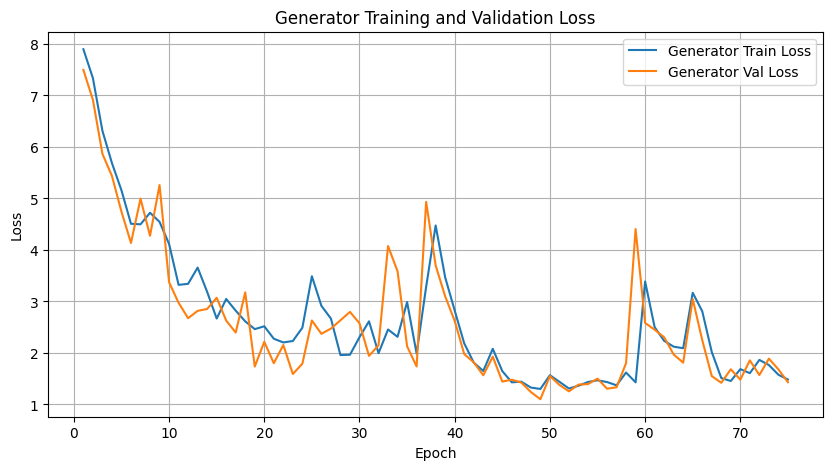

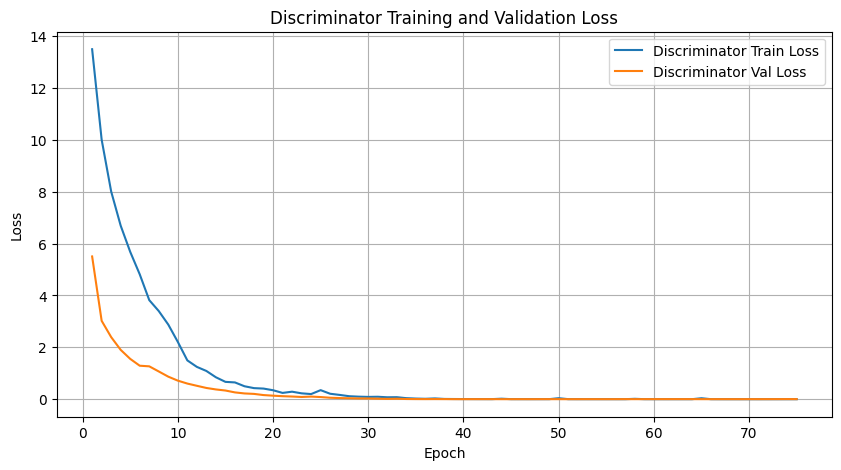

In [ ]:
plot_gans_losses(epochs,generator_training_loss,generator_validation_loss,discriminator_training_loss,discriminator_validation_loss)

In [ ]:
# --- Test DataLoader ---
dataset_test = NSynthDataset(split="test")
dataloader_test = DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=2
)


⚠️  Skipped 928 label(s) without audio files


In [ ]:
# Test for 1 batch
for cond in dataloader_test:
    z = torch.randn(cond['audio'].size(0), 128, device=device)
    cond = {k: v.to(device) for k, v in cond.items()}
    waveform_real = cond['audio']
    spec_real = make_spectrogram(waveform_real)[0]
    spec_fake = generator(cond, z)[0]
    break




In [ ]:
spec_real.shape
spec_fake.shape

torch.Size([2, 32, 256])

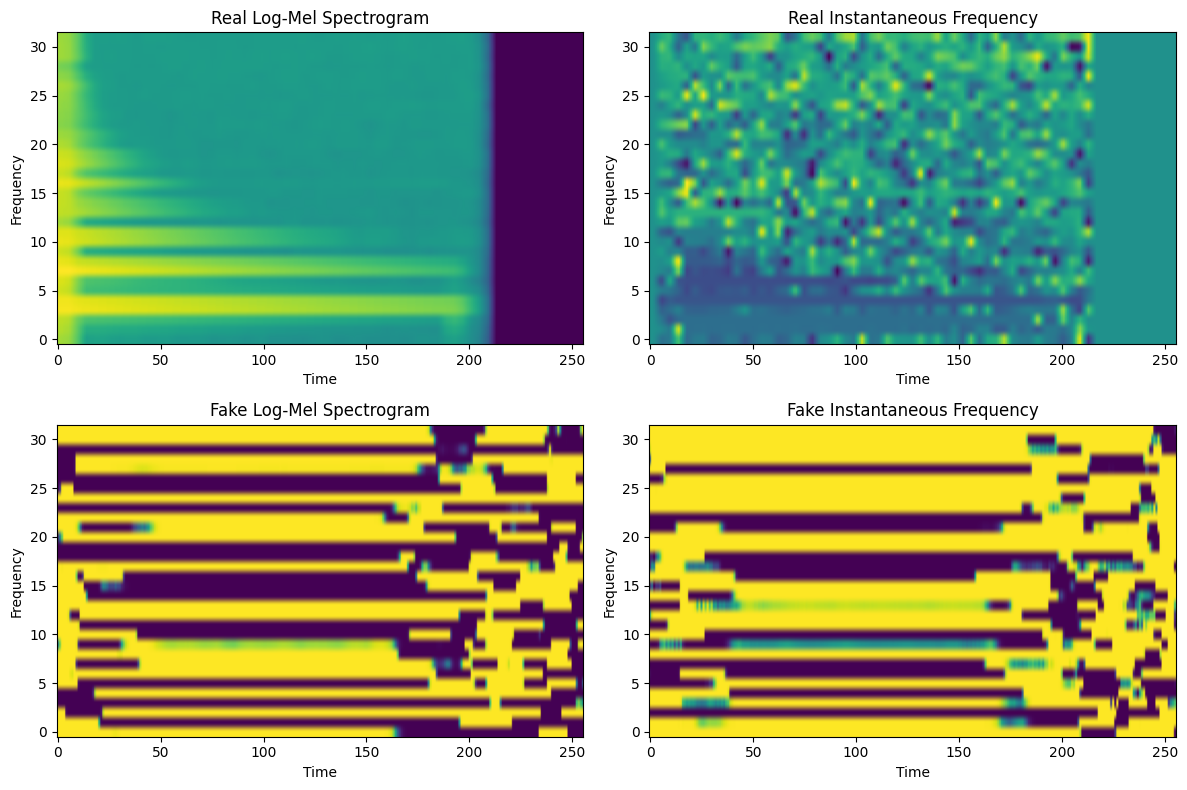

In [ ]:
def visualize_spectrograms(spec_real, spec_fake):
  spec_real = spec_real.detach().cpu().numpy()
  spec_fake = spec_fake.detach().cpu().numpy()

  spec_real_log_mel = spec_real[0]
  spec_real_inst_freq = spec_real[1]
  spec_fake_log_mel = spec_fake[0]
  spec_fake_inst_freq = spec_fake[1]


  fig, axs = plt.subplots(2, 2, figsize=(12, 8))

  # Real log-mel
  axs[0, 0].imshow(spec_real_log_mel, aspect='auto', origin='lower', cmap='viridis')
  axs[0, 0].set_title('Real Log-Mel Spectrogram')
  axs[0, 0].set_xlabel('Time')
  axs[0, 0].set_ylabel('Frequency')

  # Real inst-freq
  axs[0, 1].imshow(spec_real_inst_freq, aspect='auto', origin='lower', cmap='viridis')
  axs[0, 1].set_title('Real Instantaneous Frequency')
  axs[0, 1].set_xlabel('Time')
  axs[0, 1].set_ylabel('Frequency')

  # Fake log-mel
  axs[1, 0].imshow(spec_fake_log_mel, aspect='auto', origin='lower', cmap='viridis')
  axs[1, 0].set_title('Fake Log-Mel Spectrogram')
  axs[1, 0].set_xlabel('Time')
  axs[1, 0].set_ylabel('Frequency')

  # Fake inst-freq
  axs[1, 1].imshow(spec_fake_inst_freq, aspect='auto', origin='lower', cmap='viridis')
  axs[1, 1].set_title('Fake Instantaneous Frequency')
  axs[1, 1].set_xlabel('Time')
  axs[1, 1].set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()



visualize_spectrograms(spec_real,spec_fake)

In [ ]:
def reconstruct_audio(spectograms,sample_rate,n_fft,hop_length,n_mels):


  # Log mel spectogram

  # 1. Get spectograms
  log_mel_spectogram = spectograms[0]
  inst_freq = spectograms[1]

  # 2. Covert log mel spectogram -> mel spectogram
  mel_spectrogram = log_mel_spectogram.exp()

  # 3. From instantaneous frequency we sum to cumulative (unwrapped) phase
  dphase = inst_freq * (2 * torch.pi * hop_length) / sample_rate
  cum_phase = torch.cumsum(dphase, dim=-1)      #(n.mels, T)

  #4. Inverse mel scale to get linear-freq power spectogram
  n_freq = n_fft//2 + 1
  inv_mel = torchaudio.transforms.InverseMelScale(
      n_stft=n_freq,
      n_mels=n_mels,
      sample_rate=sample_rate,
      f_min=0,
      f_max=sample_rate//2
  ).to(device)
  power_spec = inv_mel(log_mel_spectogram)

  # 5) upsample phase from n_mels→n_freq
  phase_up = F.interpolate(
        cum_phase.unsqueeze(0).unsqueeze(0),
        size=(n_freq, cum_phase.size(1)),
        mode='bilinear',
        align_corners=False
    ).squeeze(0).squeeze(0)


  # 6) Build complex STFT
  real = power_spec * torch.cos(phase_up)
  imag = power_spec * torch.sin(phase_up)
  stft_complex = torch.complex(real, imag)

  # 7) ISTFT → waveform
  window = torch.hann_window(n_fft, device=device)
  waveform  = torch.istft(
        stft_complex,
        n_fft = n_fft,
        hop_length = hop_length,
        window = window,
        length = 4 * sample_rate
    )
  return waveform  # 1-D tensor of audio samples













In [ ]:
spec_real

tensor([[[  1.8815,   1.8815,   1.8287,  ..., -18.4207, -18.4207, -18.4207],
         [  2.4708,   2.4708,   2.4139,  ..., -18.4207, -18.4207, -18.4207],
         [  2.8614,   2.8614,   2.8131,  ..., -18.4207, -18.4207, -18.4207],
         ...,
         [  1.7438,   1.7438,   1.7066,  ..., -18.4207, -18.4207, -18.4207],
         [  1.7778,   1.7778,   1.7356,  ..., -18.4207, -18.4207, -18.4207],
         [  1.6465,   1.6465,   1.6068,  ..., -18.4207, -18.4207, -18.4207]],

        [[  0.0000,   0.0000,  -0.2196,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,  -0.0569,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,  -0.1762,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [  0.0000,   0.0000,   0.2259,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.4269,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.1779,  ...,   0.0000,   0.0000,   0.0000]]],
       device='cuda:0')

In [ ]:
reconstruct_audio(spec_real,4000,1024,256,32)

tensor([ 2.0325e-05, -2.5225e-06, -2.1588e-05,  ...,  5.7193e-06,
        -5.8810e-04, -1.0260e-03], device='cuda:0')

In [ ]:

def save_wav_torchaudio(waveform: torch.Tensor, sample_rate: int, path: str):
  waveform = waveform.to(device = 'cpu')
  if waveform.ndim == 1:
    waveform = waveform.unsqueeze(0)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torchaudio.save(path, waveform, sample_rate)
    return path

waveform = reconstruct_audio(spec_real,4000,1024,256,32)
out = save_wav_torchaudio(waveform, 4000, "./output/reconstructed.wav")
print("Wrote WAV to:", out)


Wrote WAV to: ./output/reconstructed.wav


In [ ]:
waveform_real = waveform_real[0]
save_wav_torchaudio(waveform_real, 4000, "./output/original.wav")

'./output/original.wav'

In [ ]:
waveform = reconstruct_audio(spec_fake,4000,1024,256,32)
out = save_wav_torchaudio(waveform, 4000, "./output/generated.wav")
print("Wrote WAV to:", out)

Wrote WAV to: ./output/generated.wav
